In [90]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from pyrsimg import readTiff,writeTiff,imgShow
from datetime import datetime,timedelta
import re
import os
import h5py
import pandas as pd
import statistics

In [91]:
class get_data_info:
    def __init__(self: 'get_data_info', h5_filename: str, key='ht_ortho'):
        """
        :param h5_filename: file path of .h5 file
        :param key: the field of the .h5 file
        """
        self.h5_filename = h5_filename
        self.key = key
        self.data = h5py.File(self.h5_filename, 'r')

    def open_data(self):
        return self.data

    def list_keys(self,sort=True):
        if not sort:
            print(list(self.open_data().variables.keys()))
        else:
            print(list(sorted(self.open_data().variables.keys())))

In [92]:
import h5py

class ids_data:
    def __init__(self, h5_filename: str, lat: tuple, lon: tuple | None = None, key='gt1l/ht_ortho'):
        self.data_obj = get_data_info(h5_filename, key)
        self.data = self.data_obj.open_data()
        self.lat, self.lon = lat, lon
        self.key = key
        # data point coordination
        self.dat_lon = self.data['gt1l/bottom_lon'][:]
        self.dat_lat = self.data['gt1l/bottom_lat'][:]

    def get_ids(self):
        lat = sorted(self.lat)
        if self.lon is not None:
            lon = sorted(self.lon)
            if (lat[1]-lat[0]) > (lon[1]-lon[0]):
                ids = np.where((self.dat_lat > lat[0]) & (self.dat_lat < lat[1]))
            else:
                ids = np.where((self.dat_lon > lon[0]) & (self.dat_lon < lon[1]))
        else:
            ids = np.where((self.dat_lat > lat[0]) & (self.dat_lat < lat[1]))
        return ids
    def get_elevation_data(self):
        data = self.data
        ids = self.get_ids()
        elevation_collection = data[self.key][ids]
        return elevation_collection

    def get_mean_elevation(self):
        return self.get_elevation_data().mean(axis=0)

    def get_data_time(self, choose_time: bool | None = None):
        base_timestamp = datetime(2018, 1, 1, 0, 0, 0, 0)
        if choose_time is True:
            real_timestamp = [timedelta(seconds=time)+base_timestamp for time in
                              self.data['gt1l/delta_time'][self.get_ids()]]
            return real_timestamp
        else:
            real_timestamp = [timedelta(seconds=time)+base_timestamp for time in
                              self.data['gt1l/delta_time'][:]]
            return real_timestamp

    def get_data_date(self,need_sec=False):
        # the time accuracy seconds and since 2000-01-01 00:00:00.0
        time_list = self.get_data_time()
        if len(time_list) == 0:
            raise Exception("time_list is empty")
        else:
            if len(time_list) == 1:
                first_timestamp = time_list[0]
                if need_sec is False:
                    return first_timestamp.strftime('%Y%m%d')
                else:
                    return first_timestamp.strftime('%Y%m%d%H%M%S')
            else:
                first_timestamp = time_list[0]
                end_timestamp = time_list[-1]
                first_day = first_timestamp.strftime('%Y%m%d')
                end_day = end_timestamp.strftime('%Y%m%d')
                first_sec = first_timestamp.strftime('%Y%m%d%H%M%S')
                end_sec = end_timestamp.strftime('%Y%m%d%H%M%S')
                if need_sec is False:
                    if first_day == end_day :
                        return first_day
                    else:
                        return [first_day,end_day]
                else:
                    if first_sec == end_sec :
                        return first_sec
                    else:
                        return [first_sec,end_sec]

    def show_elevation_fig(self,marker:str='.',dot_size:int=5,dot_color:str='r'):
        """
        :param marker: the marker for the scatter plot
        :param dot_size: the size of the scatter plot
        :param dot_color: the color of the scatter plot
        :return: show fig
        """
        elevation_col = self.get_elevation_data()
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(self.dat_lat[self.get_ids()],elevation_col[:],marker=marker,s=dot_size,c=dot_color)

    ## show the point on the map
    def show_map_fig(self,rsimg_path:str,marker:str='.',dot_size:int=10,dot_color:str='r'):
        """
        :param rsimg_path: the path of the rsimg
        :param marker: the marker for the scatter plot
        :param dot_size: the size of the scatter plot
        :param dot_color: the color of the scatter plot
        :return: show fig
        """
        rsimg = readTiff(rsimg_path)
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        imgShow(rsimg.array, extent=rsimg.geoextent, ax=ax)
        plt.scatter(self.dat_lon[self.get_ids()],self.dat_lat[self.get_ids()],marker=marker,s=dot_size,c=dot_color)
        return plt.show()

    def show_hist_fig(self):
        elevation_col = self.get_elevation_data()
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.hist(elevation_col)
        return plt.show()

In [93]:
# h5_data= ids_data("E:/icesat2_data/icesat2/py/111/processed_ATL13_20190801170418_05290401_006_01.h5",(24.75,24.95))
h5_data= ids_data("E:/icesat2_data/icesat2/py/data2023/processed_ATL13_20231023152039_05292101_006_01.h5",(24.75,24.95))

In [94]:
h5_data.get_data_date()[:6]

'202310'

In [95]:
h5_data.get_elevation_data()

array([1887.7552, 1887.7714, 1887.7684, 1887.7692, 1887.7705, 1887.8042,
       1887.7812, 1887.7786, 1887.761 , 1887.7521, 1887.7638, 1887.7699,
       1887.7822, 1887.7745, 1887.7759, 1887.7539, 1887.7675, 1887.78  ,
       1887.755 , 1887.7532], dtype=float32)

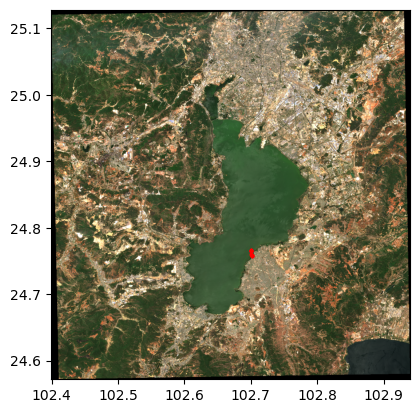

In [96]:
h5_data.show_map_fig('F:/Users/86182/Desktop/dianchi_s2_20200511_wgs84_resam50m.tif')

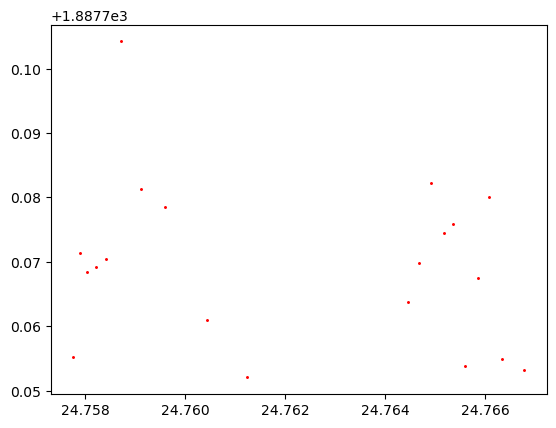

In [97]:
h5_data.show_elevation_fig()

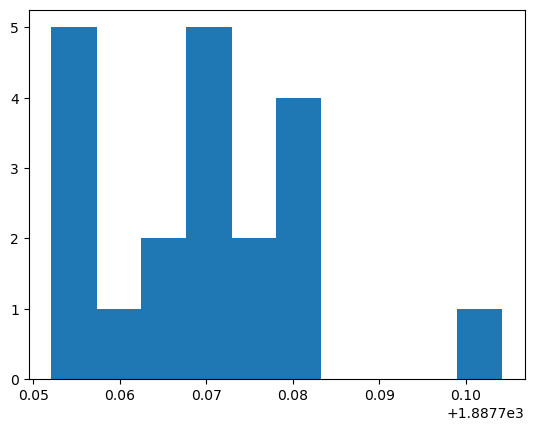

In [98]:
h5_data.show_hist_fig()

In [99]:
target_dir = r'E:\icesat2_data\icesat2\py\da'
pattern = re.compile(r'.h5')
elevation_col_month_dict = {}
for root, dirs, files in os.walk(target_dir):
    for file in files:
        h5_path = os.path.join(root, file)
        h5_data= ids_data(h5_path,(24.50,24.95))
        month = h5_data.get_data_date()[:4]+'-'+h5_data.get_data_date()[4:6]
        elevation_col_month_dict.update({month:h5_data.get_mean_elevation()})
elevation_col_month_dict

{'2019-02': 1887.7367,
 '2019-05': 1887.6125,
 '2020-01': 1887.5961,
 '2020-07': 1887.3286,
 '2020-10': 1887.6042,
 '2020-11': 1887.5475,
 '2021-01': 1887.4916,
 '2021-05': 1887.3309,
 '2022-01': 1887.5479,
 '2022-02': 1887.6432,
 '2022-07': 1887.424,
 '2023-02': 1887.5299,
 '2023-04': 1887.292,
 '2023-05': 1887.21,
 '2023-07': 1887.2881,
 '2023-10': 1887.7693}

In [100]:
def traverse_files_in_current_directory():
  os.chdir(r'E:\icesat2_data\icesat2\py\da')
  current_directory = os.getcwd()  # 获取当前目录
  for filename in os.listdir(current_directory):
      if os.path.isfile(filename):  # 判断是否是文件
          print(filename)
          h5_data= ids_data(filename,(24.50,24.95))
          month = h5_data.get_data_date()[:4]+'-'+h5_data.get_data_date()[4:6]
          elevation_col_month_dict.update({month:h5_data.get_mean_elevation()})
traverse_files_in_current_directory()

processed_ATL13_20190201014500_05290201_006_01.h5
processed_ATL13_20190212141955_07050201_006_01.h5
processed_ATL13_20190514095935_07050301_006_01.h5
processed_ATL13_20200130082359_05290601_006_01.h5
processed_ATL13_20200729234333_05290801_006_01.h5
processed_ATL13_20201028192320_05290901_006_01.h5
processed_ATL13_20201109075818_07050901_006_01.h5
processed_ATL13_20210127150315_05291001_006_01.h5
processed_ATL13_20210509231805_07051101_006_01.h5
processed_ATL13_20220125214246_05291401_006_01.h5
processed_ATL13_20220206101745_07051401_006_01.h5
processed_ATL13_20220726130238_05291601_006_01.h5
processed_ATL13_20230204165710_07051801_006_02.h5
processed_ATL13_20230425000153_05291901_006_01.h5
processed_ATL13_20230506123651_07051901_006_01.h5
processed_ATL13_20230724194106_05292001_006_01.h5
processed_ATL13_20231023152039_05292101_006_01.h5


In [101]:
targrt_dir=r"E:\icesat2_data\icesat2\py\da"
data_pattern=re.compile(r".h5")
point_extent = []
pd_elevation = pd.DataFrame()
for root, dirs, files in os.walk(target_dir):
    for file in files:
        match = data_pattern.search(file)
        if match:
            h5_path = os.path.join(root, file)
            h5_data= ids_data(h5_path,(24.50,24.95))
            month = h5_data.get_data_date()[4:6]
            year = h5_data.get_data_date()[:4]
            year_month = year+'-'+month
            avg_elevation_month = h5_data.get_mean_elevation()
            # mid_elevation_month = h5_data.get_mid_elevation()
            # each_extent = h5_data.get_point_extent()
            pd_elevation =pd_elevation._append({'year_month':year_month,'year':year,'month':month,'avg_elevation':avg_elevation_month},ignore_index=True)
pd_elevation


,year_month,year,month,avg_elevation
0,2019-02,2019,02,1887.756348
1,2019-02,2019,02,1887.736694
2,2019-05,2019,05,1887.612549
3,2020-01,2020,01,1887.596069
4,2020-07,2020,07,1887.328613
5,2020-10,2020,10,1887.604248
6,2020-11,2020,11,1887.547485
7,2021-01,2021,01,1887.491577
8,2021-05,2021,05,1887.330933
9,2022-01,2022,01,1887.547852


1887.5122788373162


Text(0.5, 1.0, 'Monthly average water changes ')

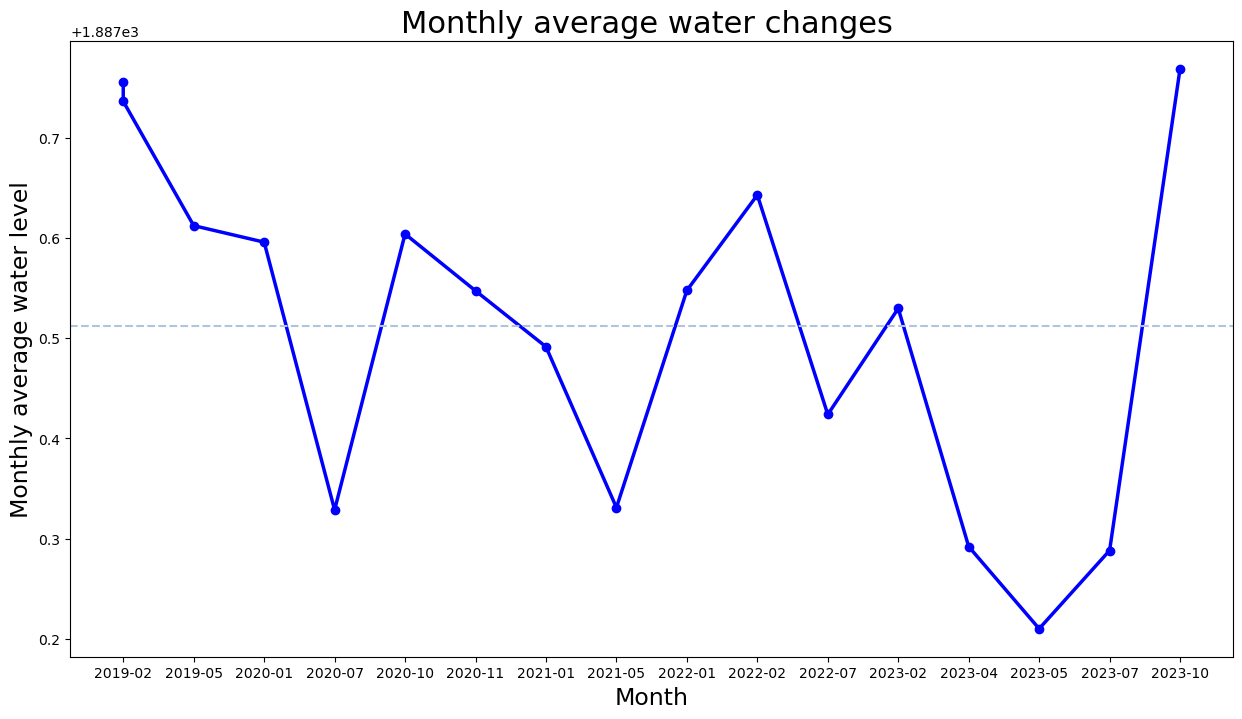

In [102]:
year_month = list(pd_elevation['year_month'])
month_elevation = list(pd_elevation['avg_elevation'])
month_elevation_all_mean = statistics.mean(month_elevation)
print(abs(month_elevation_all_mean))
# elevation_month
plt.figure(figsize=(15,8))
plt.plot(year_month,month_elevation,label='Monthly average water level changes',marker='o',color='#0000FF',linewidth=2.5)
plt.axhline(y=month_elevation_all_mean, xmin=0, xmax=len(year_month), color='lightsteelblue', linestyle='--')
plt.xlabel('Month',fontsize=17)
plt.ylabel('Monthly average water level',fontsize=17)
plt.title('Monthly average water changes ',fontsize = 22)